<a href="https://colab.research.google.com/github/josh-truong/digit-classification/blob/main/digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [231]:
# # Uncomment if kaggle dependency is missing
# !pip install -q kaggle

In [232]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec
from google.colab import files
%matplotlib inline

In [233]:
# # Uncomment if MNIST dataset is missing
# # Upload kaggle.json file
# files.upload()

# # Move kaggle.json to .kaggle
# !mkdir .kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Download MNIST dataset from kaggle
# !kaggle competitions download -c digit-recognizer
# !mkdir mnist
# !unzip digit-recognizer.zip -d mnist

# # Remove unused files
# !rm -r sample_data/
# !rm digit-recognizer.zip
# !rm mnist/sample_submission.csv

# Helper Functions

In [234]:
def show_images(images, size=4):
  images = np.array([images]) if (len(images.shape) != 2) else images
  indices = np.random.choice(len(images), size=(size*size), replace=True)
  images = images[indices, :]

  fig = plt.figure(figsize=(size+1, size+1))
  gs = gridspec.GridSpec(size, size,
          wspace=0.0, hspace=0.0, 
          top=1.-0.5/(size+1), bottom=0.5/(size+1), 
          left=0.5/(size+1), right=1-0.5/(size+1)) 

  for n, img in enumerate(images):
    row, col = n // size, n % size
    ax = plt.subplot(gs[row, col])
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.imshow(img.reshape(28,28))

# MNIST Dataset
Kaggles MNIST dataset contains 785 columns representing a 28x28 image label(1) and pixel values(784). The pixel values of the image can range from 0 to 255.

https://www.kaggle.com/competitions/digit-recognizer

In [235]:
# Validation set
test_data = pd.read_csv('mnist/test.csv')
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [236]:
# Training set
train_data = pd.read_csv('mnist/train.csv')
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [237]:
# Convert pandas dataframe to numpy array
test_data = test_data.to_numpy()
train_data = train_data.to_numpy()

# X_train, Y_train
X_train = train_data[:,1::]
Y_train = train_data[:, 0]

# X_test, Y_test
X_test = test_data[:,1::]
Y_test = test_data[:, 0]

# Data normalization
A common practice for training a Neural Network is to normalize the dataset such that the features are on a similar scale.

Improving performance and convergence(training stability).

Therefore, the image pixel values should be divided by 255.

In [238]:
X_train = X_train / 255
X_test = X_test / 255

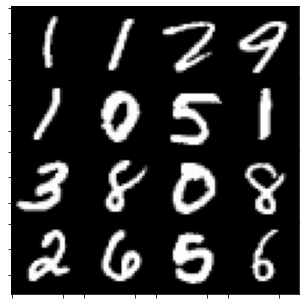

In [239]:
show_images(X_train)

#  Build a Neural Network from Scratch 
Building a neural netowork from scratch, then applying it to digit-classification using MNIST dataset

Given a 28x28 pixel images → 784 pixels. \\
Where $n = 784$ pixels and $I_i$ is the intensity of pixel $i$.

$$X = \begin{bmatrix} I_1 \\ I_2 \\ \text{...} \\ I_n \end{bmatrix}$$

$a^{j}_{i}$ is the "activation" of unit $i$ in layer $j$.

$\theta^j$ is the matrix of weights controlling function mapping from layer $j$ to layer $j+1$.

$h_{\theta}(x)$

# Multi-label Classification: Activation Functions
[Reference](https://medium.com/@cmukesh8688/activation-functions-sigmoid-tanh-relu-leaky-relu-softmax-50d3778dcea5)
- If there's more than one "right answer" use a sigmoid function
  - Sigmoid functions will allow for assignment of high probability to all classes
$$S(\vec{z}) = \frac{1}{1+e^{-z}}$$
- If there's only one "right answer" use a softmax function
  - Softmax function will enforce that the sum of probabilities of the output class to equal one.
$$\sigma(\vec{z})_i = \frac{e^{z_i}}{\sum^{j=1}_{K} (e^{z_i})}$$
    - $\sigma$ is softmax
    - $\vec{z}$ is the input vector
    - $K$ is the number of classes in the multi-label classifier
    - $e^{z_i}$ is the standard exponential function for input vector
    - $e^{z_j}$ is the standard exponential function for output vector
- Tanh converges quicker than sigmoid and logistic functions, and yields better accuracy.
- ReLu(rectified linear unit) most popular activation function. Trains six times faster than tanh
- LReLU(leaky rectified linear unit) developed to overcome one of the major shortcomings of ReLU.


In [253]:
class Activations:
  def sigmoid(self, z):
    """Compute the sigmoid of vector z."""
    return 1.0 / (1 + np.exp(-z))

  def sigmoid_prime(self, z):
    """Compute the sigmoid derivative of vector z."""
    return self.sigmoid(z) * (1 - self.sigmoid(z))

  def tanh(self, z):
    """Compute the tanh of vector z."""
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

  def tanh_prime(self, z):
    """Compute the tanh derivative of vector z."""
    return 1 - np.power(self.tanh(z), 2)

  def relu(z):
    """Compute the ReLU of vector z."""
    return np.max(0, z)

  def relu_prime(z):
    """Compute the ReLU derivative of vector z."""
    return z > 0

  def leakyrelu(z, alpha):
    """Compute the leakyrelu of vector z."""
    return np.max(alpha * z, z)

  def leakyrelu_prime(z, alpha):
    """Compute the leakyrelu derivative of vector z."""
    return 1 if z > 0 else alpha

  def softmax(z):
    """Compute the softmax of vector z."""
    exps = np.exp(z - z.max())
    return exps / np.sum(exps)